In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import pandas as pd

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2, SelectKBest

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#copied from generate chi2
df = pd.read_csv("cleaned_data.csv")
df = df.drop(columns=df.columns.values[0:2])
df = df.dropna()

df_jokes = df[df['joke'] > 0]
df_non_jokes = df[df['joke'] < 0]

df = pd.concat([df_jokes.sample(25000, random_state=42),
                df_non_jokes.sample(25000, random_state=42)])

X = df.loc[:, 'cleaned text']
y = df.loc[:, 'joke']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

tfidf = TfidfVectorizer(ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


chi_200 = SelectKBest(chi2, k=200)
chi_500 = SelectKBest(chi2, k=500)

X_train_tfidf_200_chi = chi_200.fit_transform(X_train_tfidf, y_train)
X_train_tfidf_500_chi = chi_500.fit_transform(X_train_tfidf, y_train)
X_test_tfidf_200_chi = chi_200.transform(X_test_tfidf)
X_test_tfidf_500_chi = chi_500.transform(X_test_tfidf)


data = [{
    'name' : 'TfIdf Chi 200',
    'X_train' : X_train_tfidf_200_chi,
    'X_test' : X_test_tfidf_200_chi,
    'y_train' : y_train,
    'y_test' : y_test
},{
    'name' : 'TfIdf Chi 500',
    'X_train' : X_train_tfidf_500_chi,
    'X_test' : X_test_tfidf_500_chi,
    'y_train' : y_train,
    'y_test' : y_test
}]

del df
del X
del y
del X_train
del X_test
del tfidf
del chi_200
del chi_500
del X_train_tfidf
del X_test_tfidf

In [ ]:
#word 2 vec
train_df = pd.read_csv('Word2Vec train.csv').dropna()
test_df = pd.read_csv('Word2Vec test.csv').dropna()

X_train = train_df.drop('label', axis=1)
y_train = train_df['label']
X_test = test_df.drop('label', axis=1)
y_test = test_df['label']


data.append({
    'name' : 'Word2Vec',
    'X_train' : X_train,
    'X_test' : X_test,
    'y_train' : y_train,
    'y_test' : y_test
})

del train_df
del test_df

In [ ]:
#svd
y_train = pd.read_csv('svd-train-labels.csv', header=None).iloc[:,0]
y_test = pd.read_csv('svd-test-labels.csv', header=None).iloc[:,0]
X_train_200 = pd.read_csv('svd-200-train.csv', header=None)
X_test_200 = pd.read_csv('svd-200-test.csv', header=None)
X_train_500 = pd.read_csv('svd-500-train.csv', header=None)
X_test_500 = pd.read_csv('svd-500-test.csv', header=None)

data.append({
    'name' : 'TfIdf SVD 200',
    'X_train' : X_train_200,
    'X_test' : X_test_200,
    'y_train' : y_train,
    'y_test' : y_test
})
data.append({
    'name' : 'TfIdf SVD 500',
    'X_train' : X_train_500,
    'X_test' : X_test_500,
    'y_train' : y_train,
    'y_test' : y_test
})

In [ ]:
logis = {
    'name' : 'LogisticRegression',
    'model' : LogisticRegression() 
}

dec = {
    'name' : 'DecisionTree',
    'model' : DecisionTreeClassifier() 
}

rando = {
    'name' : 'RandomForest',
    'model' : RandomForestClassifier() 
}

xgb = {
    'name' : 'XGBoost',
    'model' : XGBClassifier(eval_metric="logloss") 
}

svc = {
    'name' : 'SVC',
    'model' : SVC()
}



models = [logis, dec, rando, xgb, svc]

In [ ]:
results = []
confusions = []

for datapoint in data:
    X_train = datapoint['X_train']
    X_test = datapoint['X_test']
    y_train = datapoint['y_train']
    y_test = datapoint['y_test']
    datapoint_name = datapoint['name']

    print('Doing model for ' + datapoint_name)

    for model_dict in models:
        model_name = model_dict['name']
        model = model_dict['model']

        print('\tDoing model for ' + model_name, end='')

        start = datetime.now()

        model.fit(X_train, y_train)
        
        y_pred_train = model.predict(X_train)
        y_pred = model.predict(X_test)

        acc_train = accuracy_score(y_train, y_pred_train)
        acc_test = accuracy_score(y_test, y_pred)

        f1_train = f1_score(y_train, y_pred_train)
        f1_test = f1_score(y_test, y_pred)

        pre_train = precision_score(y_train, y_pred_train)
        pre_test = precision_score(y_test, y_pred)

        rec_train = recall_score(y_train, y_pred_train)
        rec_test = recall_score(y_test, y_pred)

        confusions.append({
            'Preprocessing' : datapoint_name,
            'Model' : model_name,
            'train' : confusion_matrix(y_train, y_pred_train),
            'test' : confusion_matrix(y_test, y_pred)
        })

        results.append([datapoint_name, model_name, acc_train, acc_test, f1_train, f1_test, pre_train, pre_test, rec_train, rec_test])

        timetake = datetime.now() - start
        print('  Time taken: ' + str(timetake))

results_df = pd.DataFrame(results, columns=['Preprocessing', 'Model Name', 'Train accuracy', 'Test accuracy', 'Train F1', 'Test F1',
                                            'Train Precision', 'Test Precision', 'Train Recall', 'Test recall'])

Doing model for TfIdf Chi 200
	Doing model for LogisticRegression  Time taken: 0:00:00.208426
	Doing model for DecisionTree  Time taken: 0:00:01.103523
	Doing model for RandomForest  Time taken: 0:00:14.652377
	Doing model for XGBoost  Time taken: 0:00:01.884458
	Doing model for SVC  Time taken: 0:00:36.874689
Doing model for TfIdf Chi 500
	Doing model for LogisticRegression  Time taken: 0:00:00.164780
	Doing model for DecisionTree  Time taken: 0:00:01.862350
	Doing model for RandomForest  Time taken: 0:00:19.811899
	Doing model for XGBoost  Time taken: 0:00:01.354318
	Doing model for SVC  Time taken: 0:01:04.730586
Doing model for Word2Vec
	Doing model for LogisticRegression  Time taken: 0:00:01.234850
	Doing model for DecisionTree  Time taken: 0:00:30.553630
	Doing model for RandomForest  Time taken: 0:01:29.313709
	Doing model for XGBoost  Time taken: 0:00:15.545629
	Doing model for SVC  Time taken: 0:09:40.746490
Doing model for TfIdf SVD 200
	Doing model for LogisticRegression  Ti

In [ ]:
results_df

,Preprocessing,Model Name,Train accuracy,Test accuracy,Train F1,Test F1,Train Precision,Test Precision,Train Recall,Test recall
0,TfIdf Chi 200,LogisticRegression,0.866150,0.865200,0.854321,0.854804,0.935913,0.931018,0.785814,0.790123
1,TfIdf Chi 200,DecisionTree,0.969100,0.830200,0.969994,0.848636,0.941737,0.768238,1.000000,0.947830
2,TfIdf Chi 200,RandomForest,0.969025,0.868900,0.969921,0.880590,0.941687,0.811482,0.999900,0.962565
3,TfIdf Chi 200,XGBoost,0.935000,0.887500,0.937256,0.896742,0.904893,0.831773,0.972019,0.972720
4,TfIdf Chi 200,SVC,0.925775,0.885300,0.927679,0.894626,0.903535,0.830462,0.953148,0.969534
5,TfIdf Chi 500,LogisticRegression,0.895450,0.894400,0.888966,0.888112,0.946568,0.949049,0.837972,0.834528
6,TfIdf Chi 500,DecisionTree,0.993950,0.845500,0.993980,0.860421,0.988032,0.787498,1.000000,0.948228
7,TfIdf Chi 500,RandomForest,0.993900,0.886100,0.993930,0.894839,0.987934,0.834223,1.000000,0.964954
8,TfIdf Chi 500,XGBoost,0.957650,0.890400,0.958444,0.899394,0.939815,0.834298,0.977826,0.975508
9,TfIdf Chi 500,SVC,0.959550,0.911200,0.959839,0.916620,0.951994,0.867271,0.967815,0.971924


In [ ]:
results_df.to_csv('results with svc.csv')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

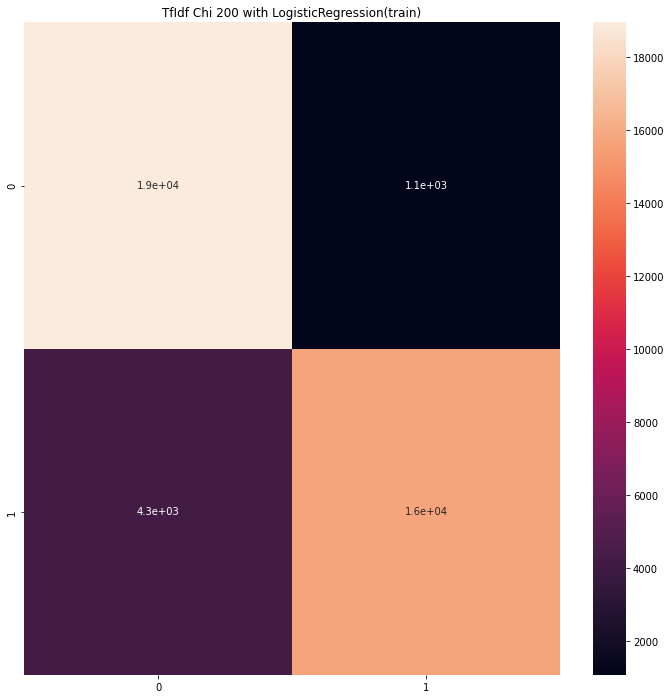

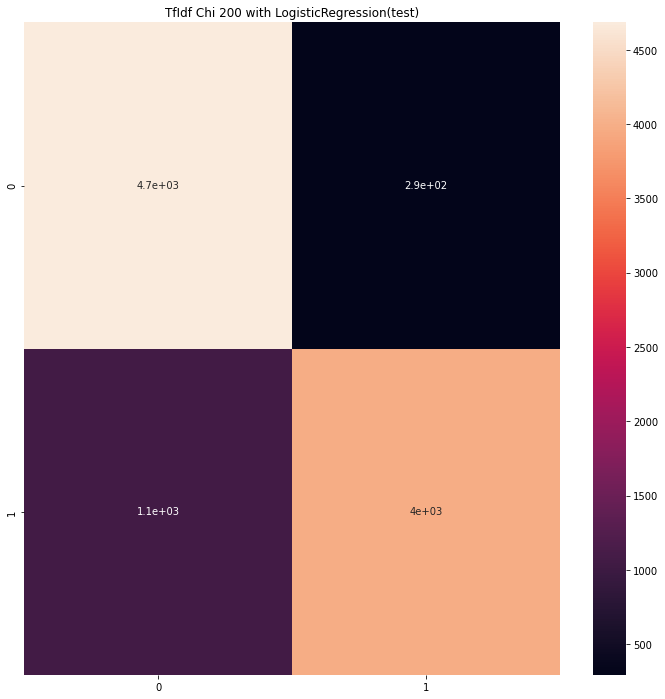

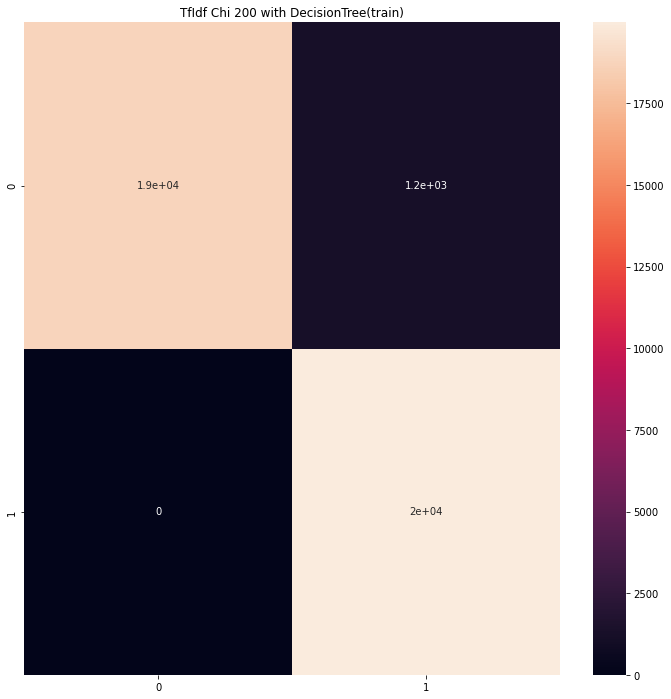

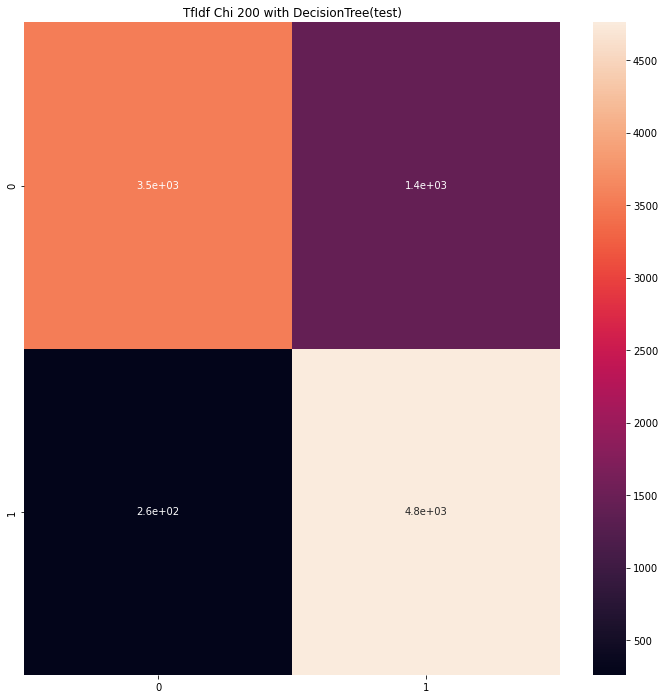

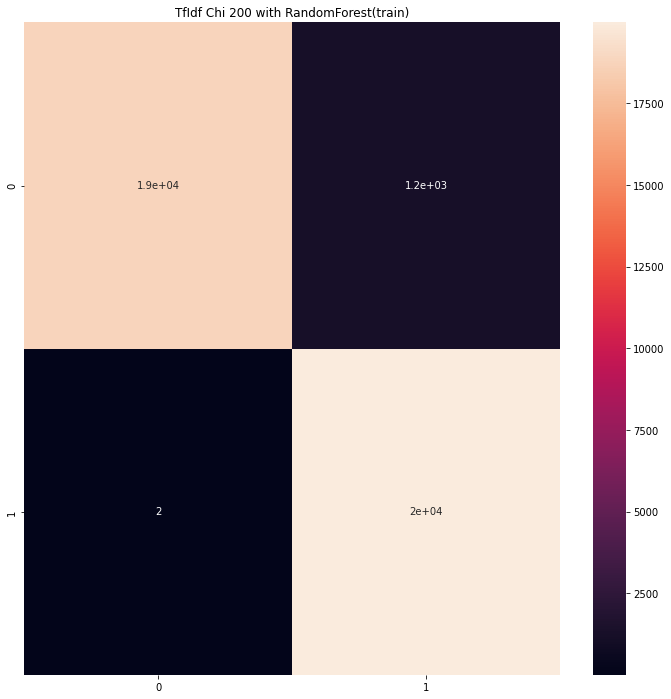

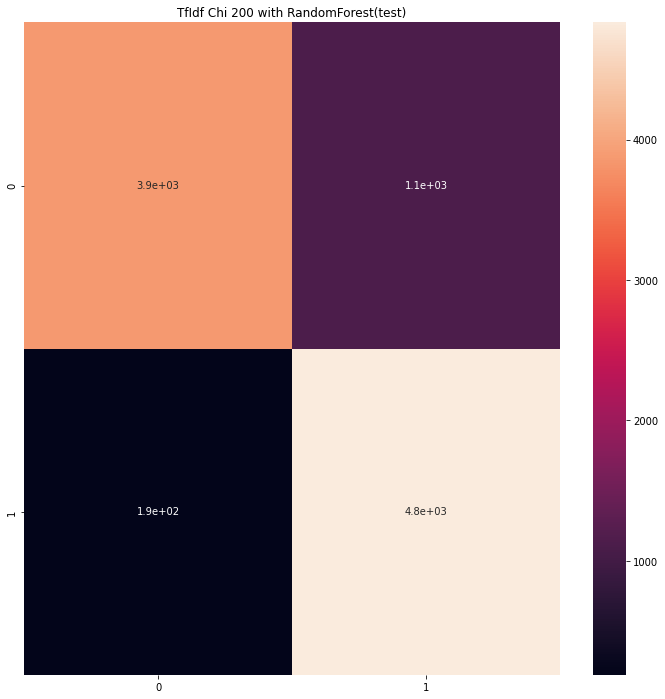

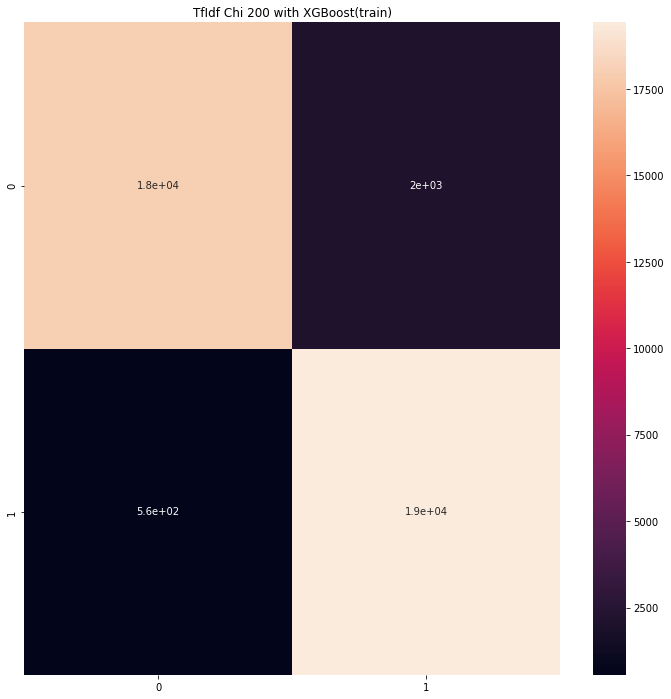

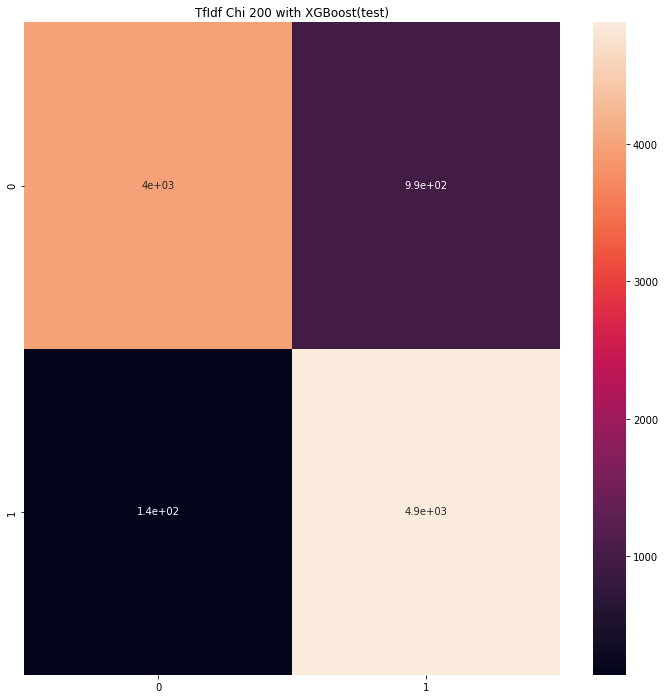

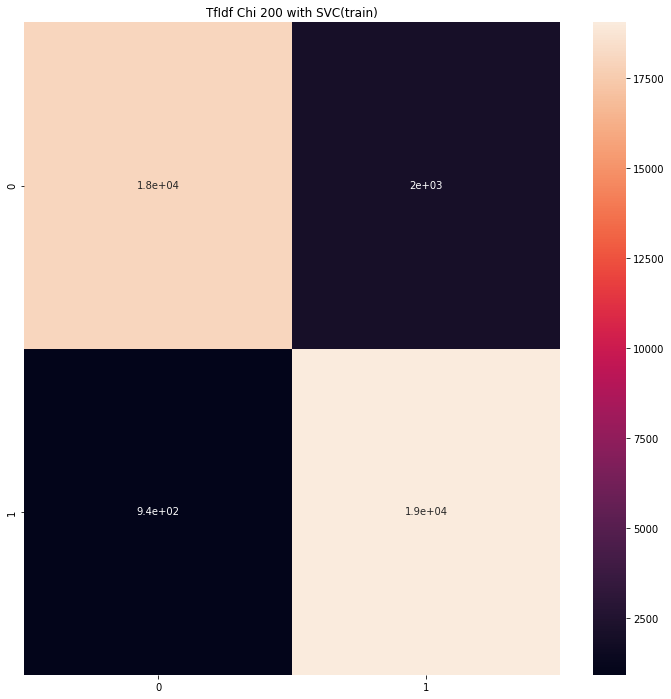

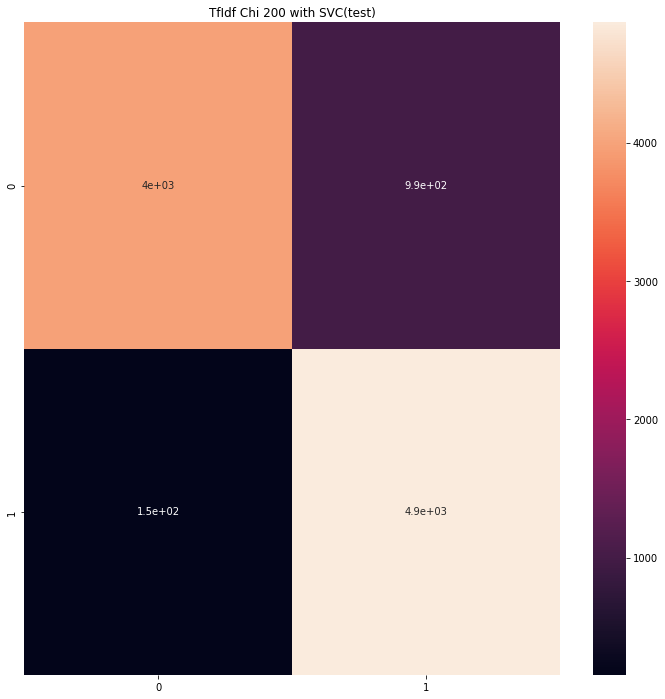

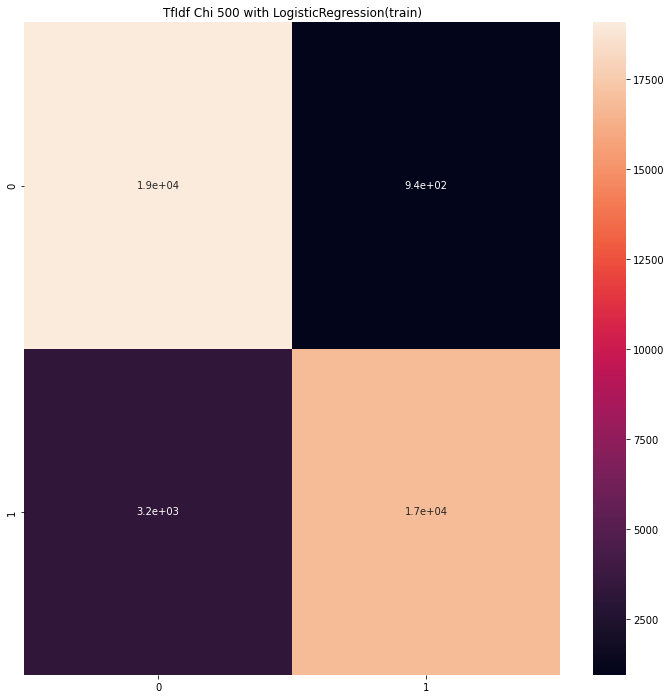

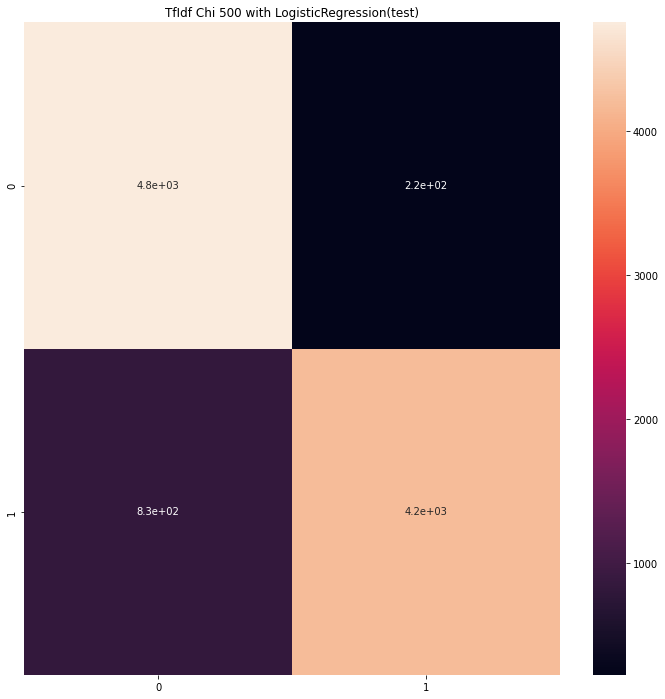

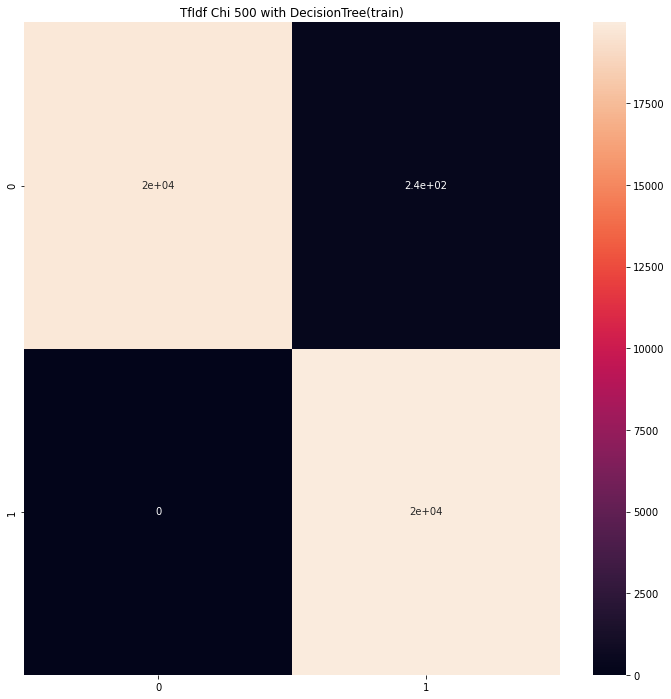

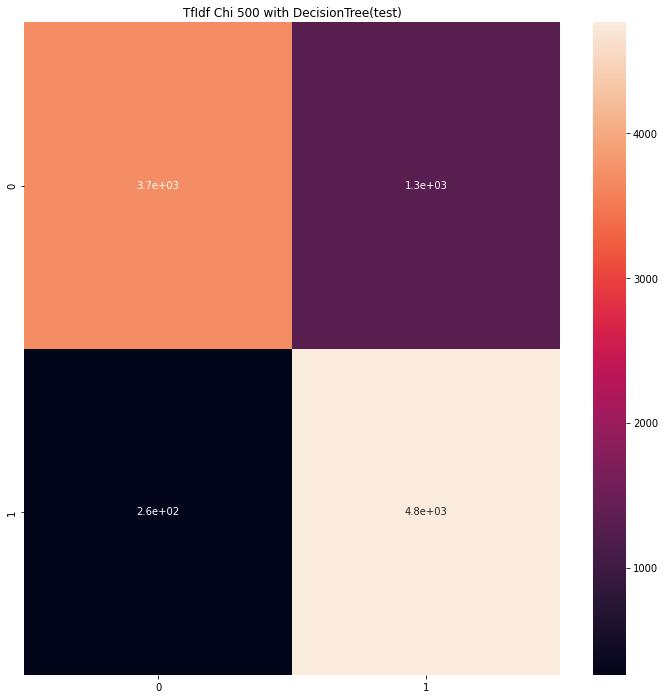

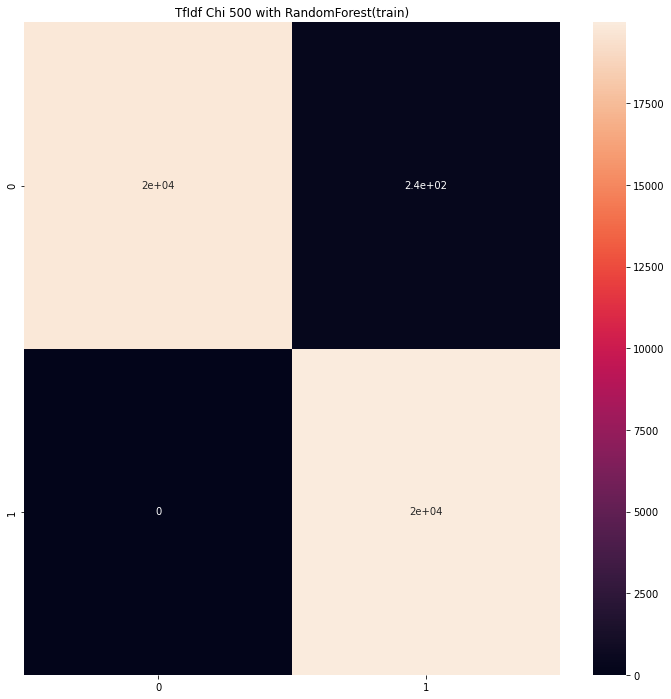

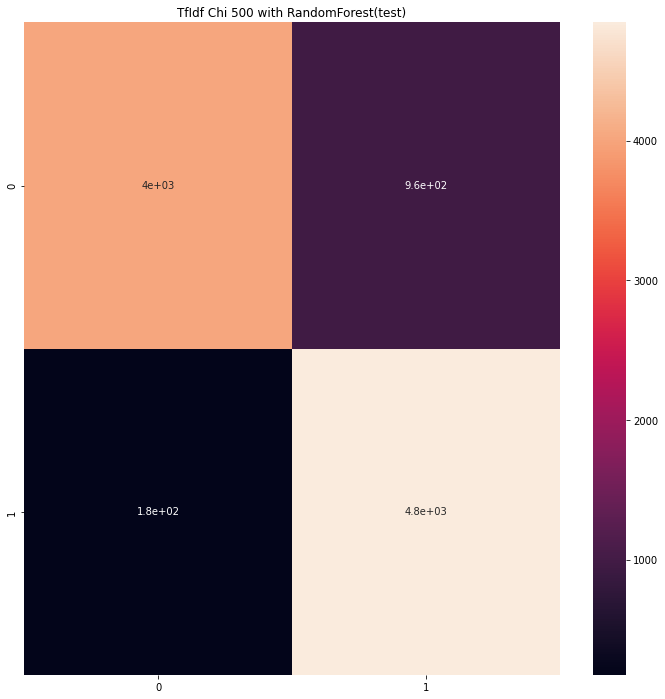

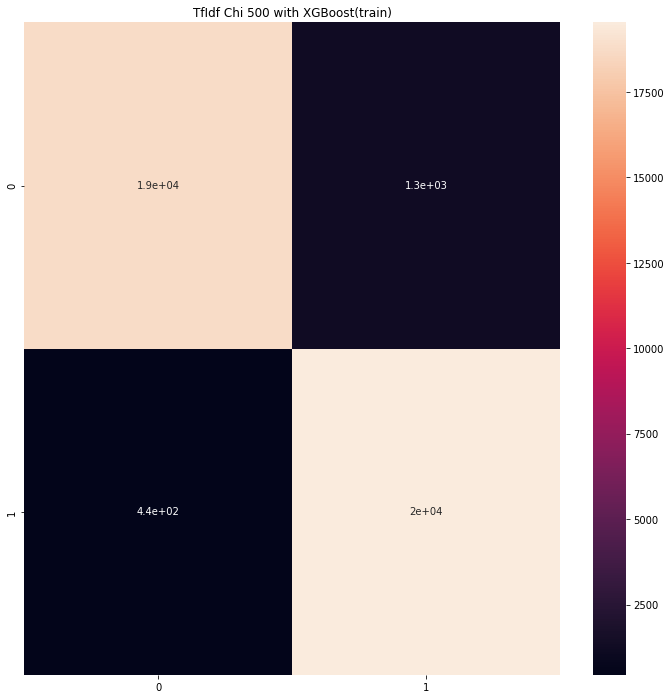

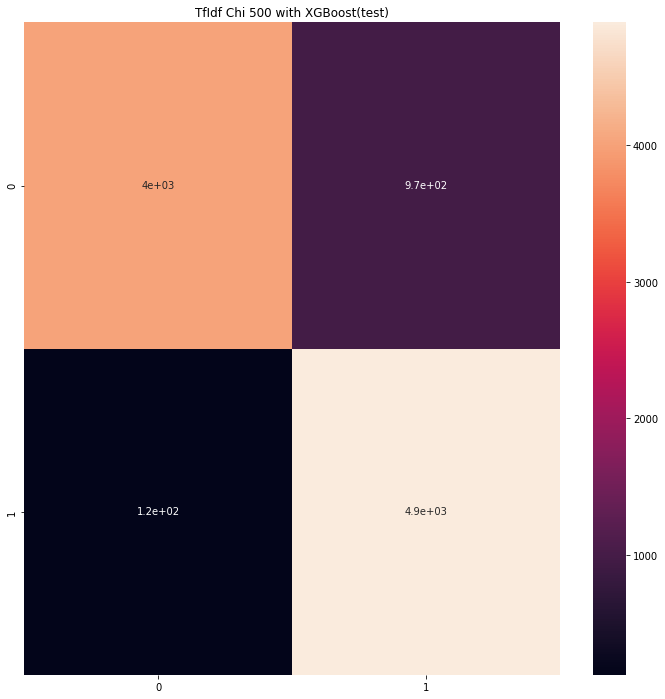

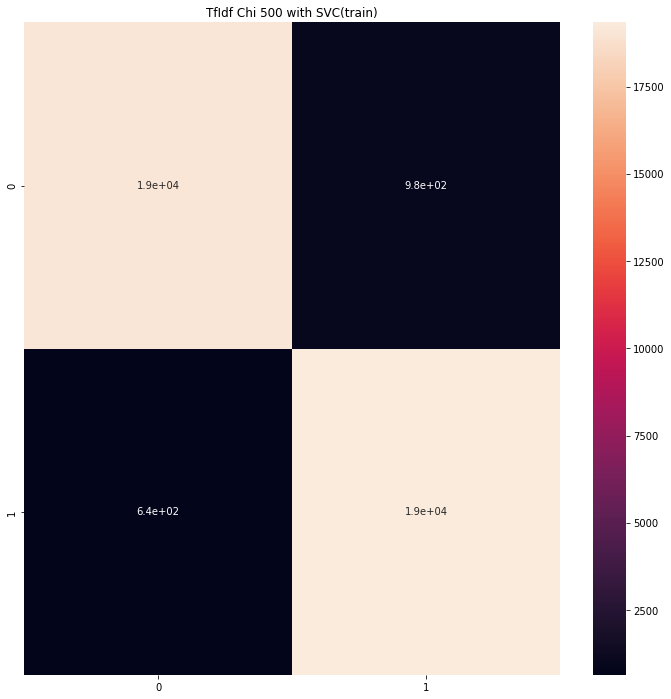

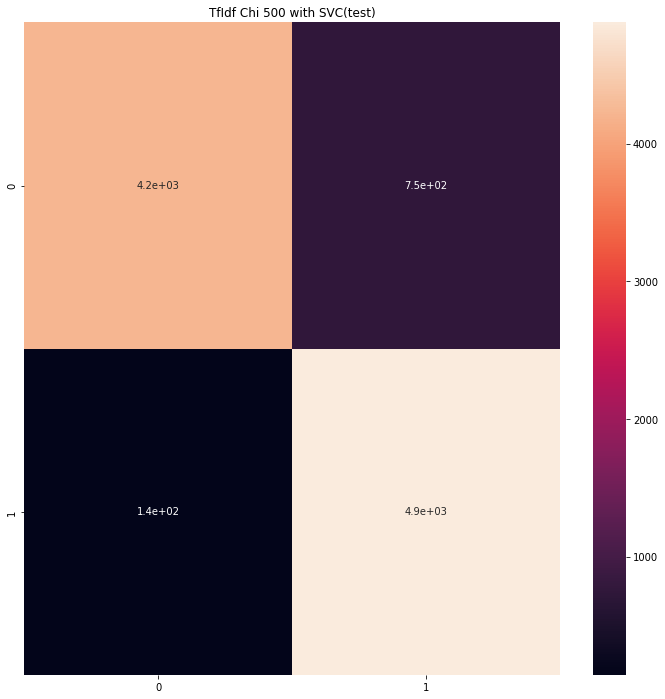

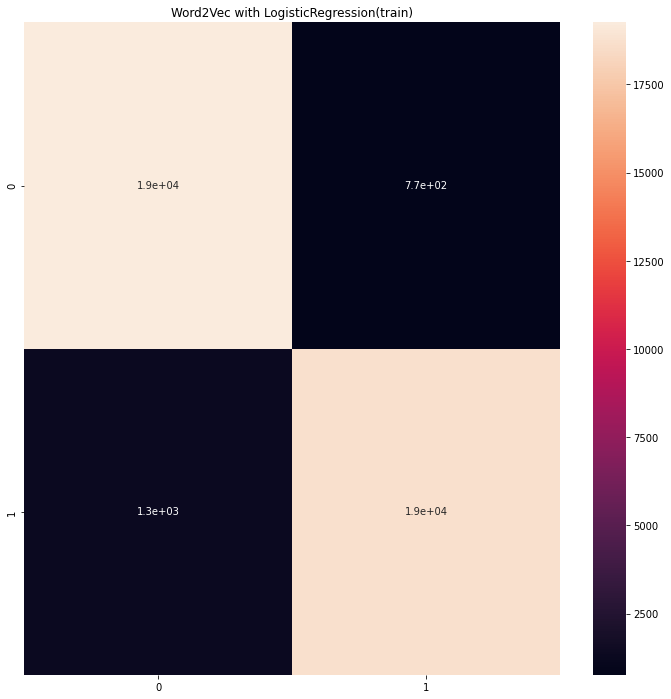

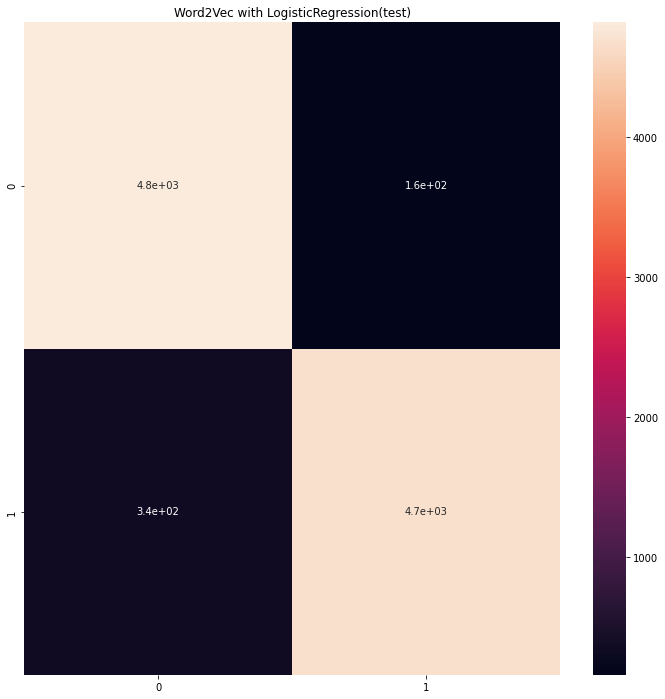

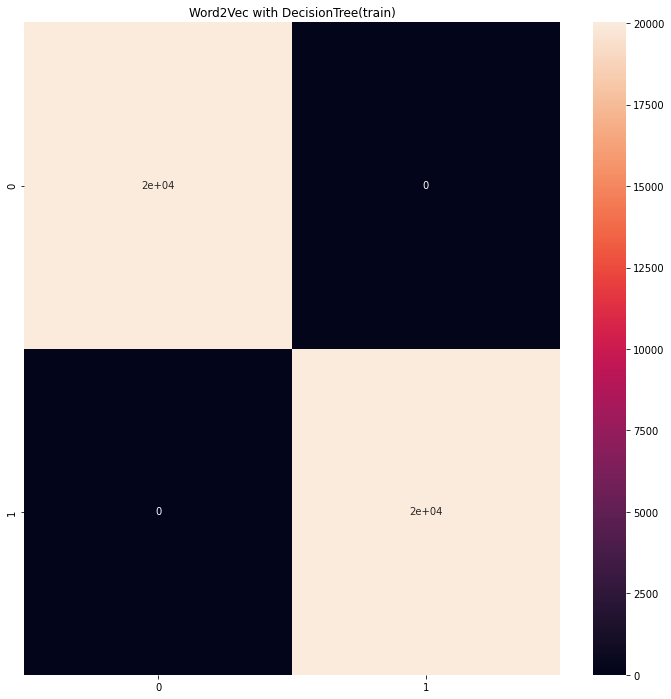

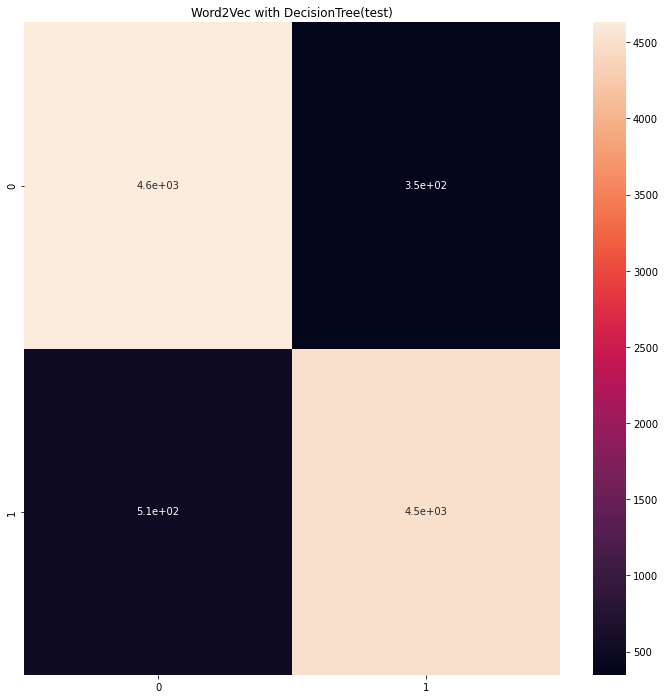

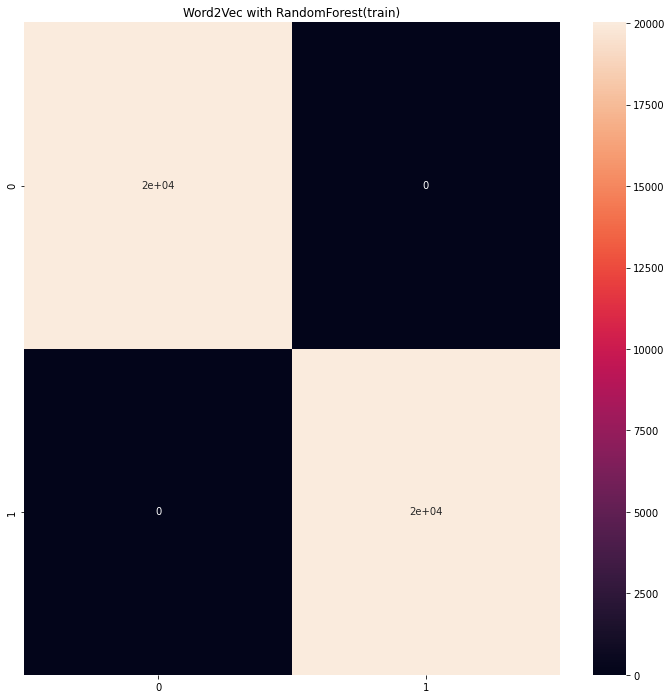

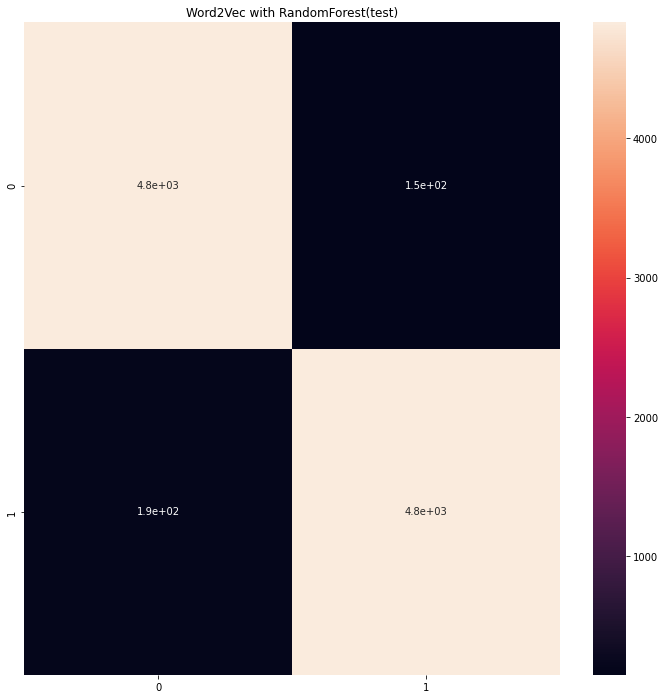

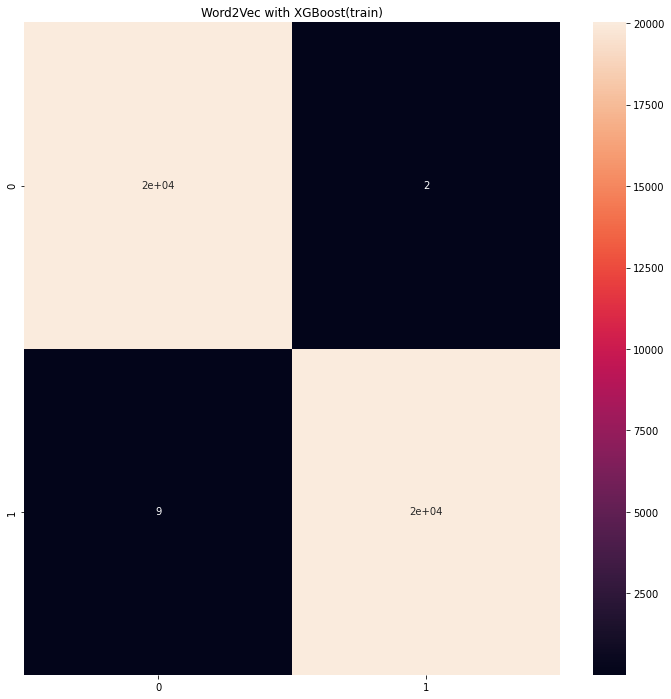

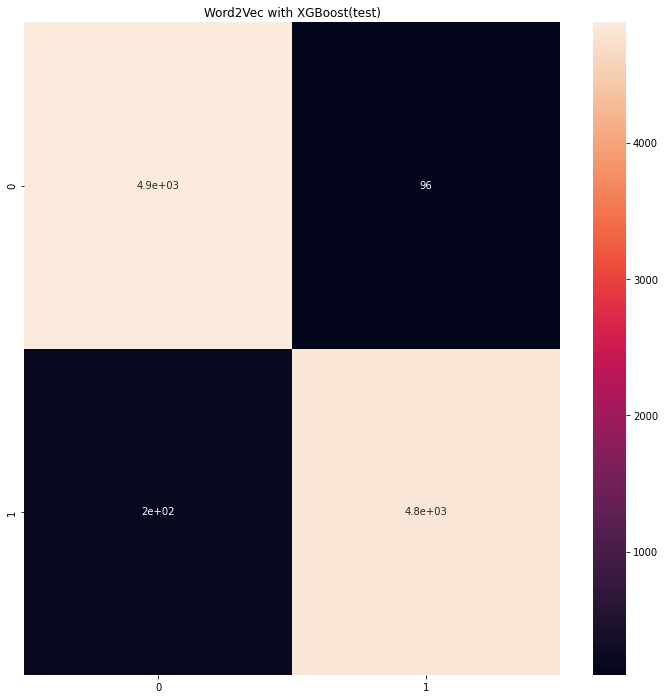

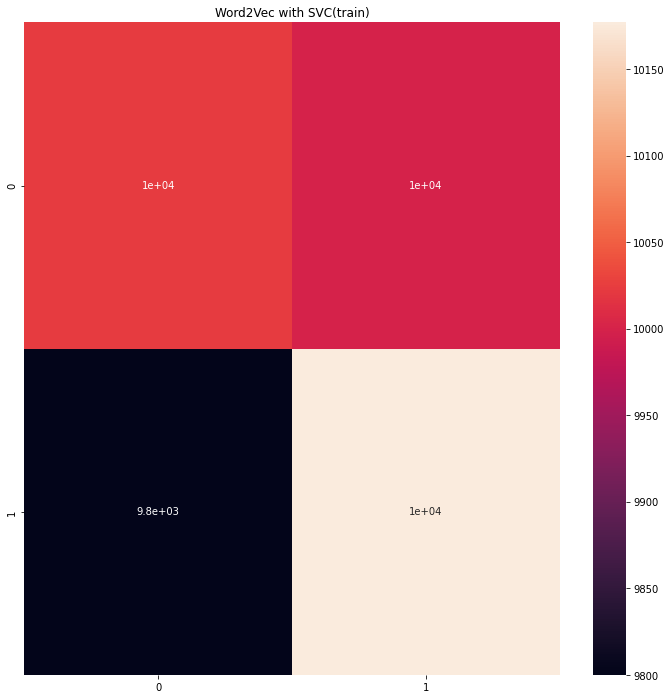

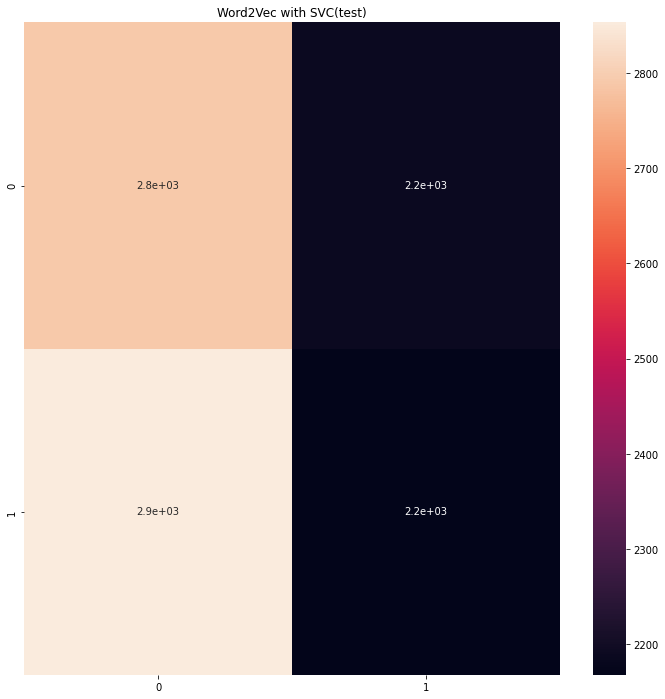

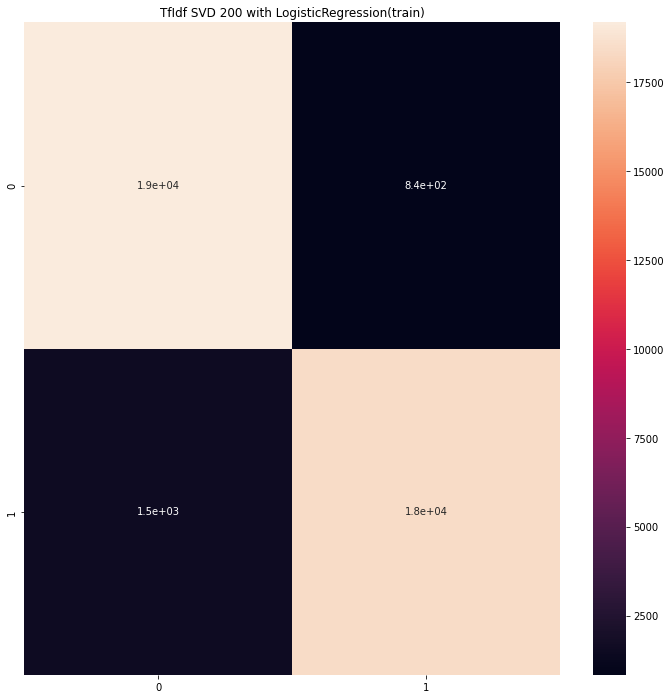

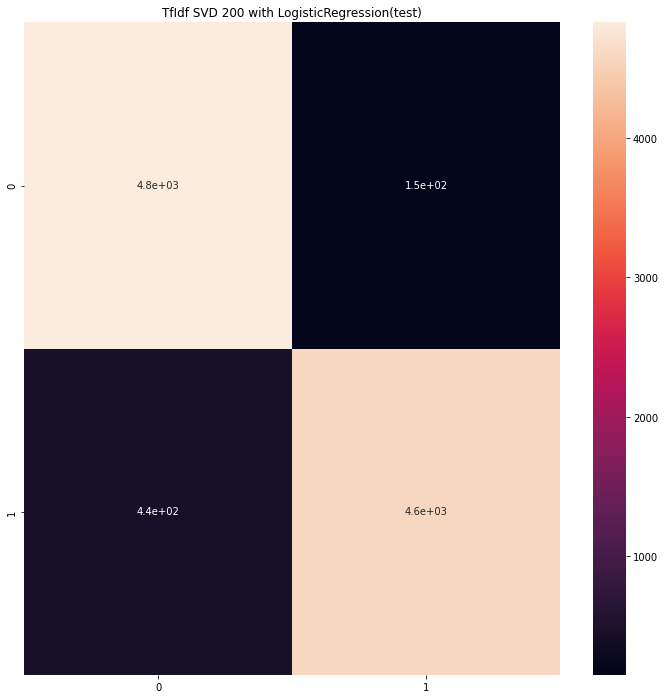

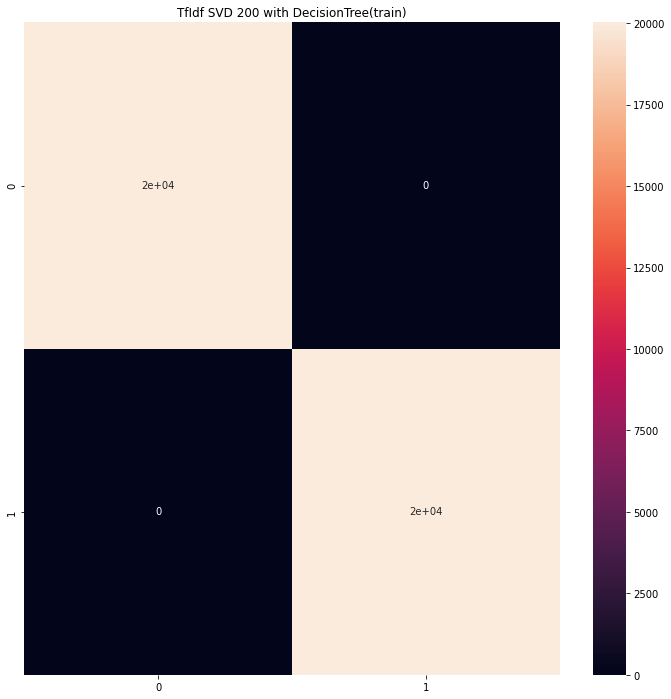

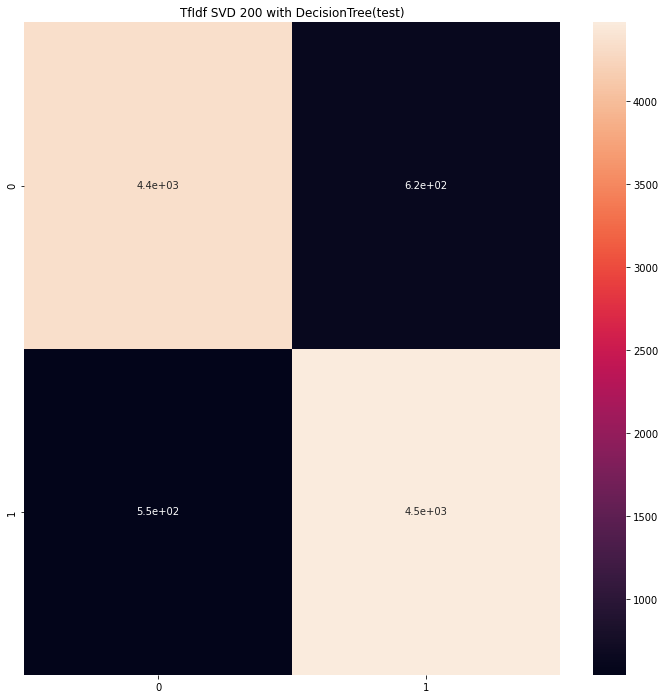

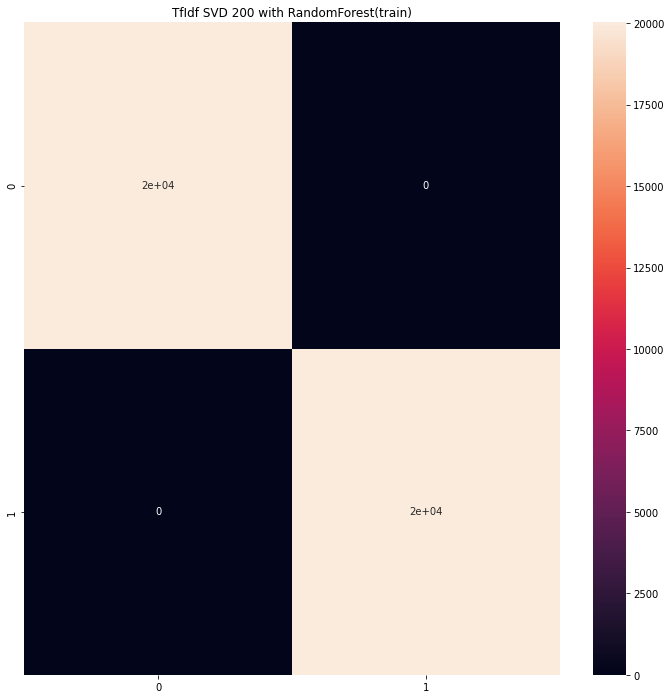

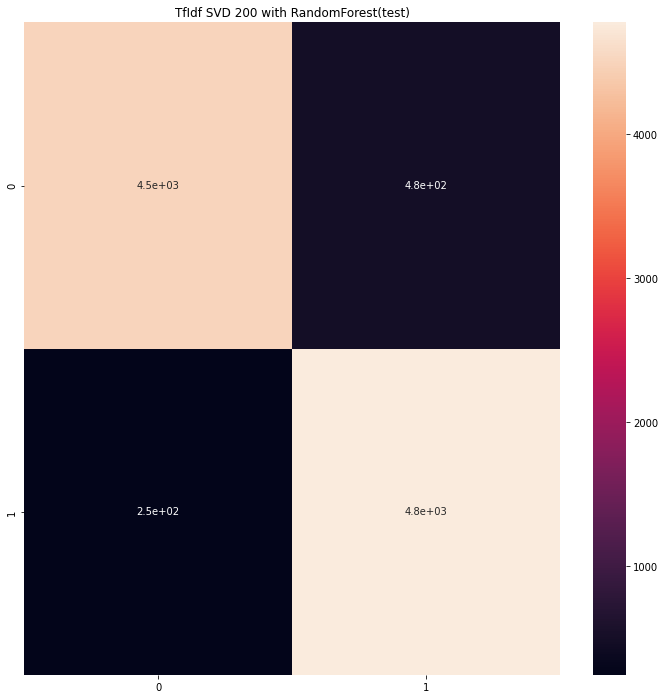

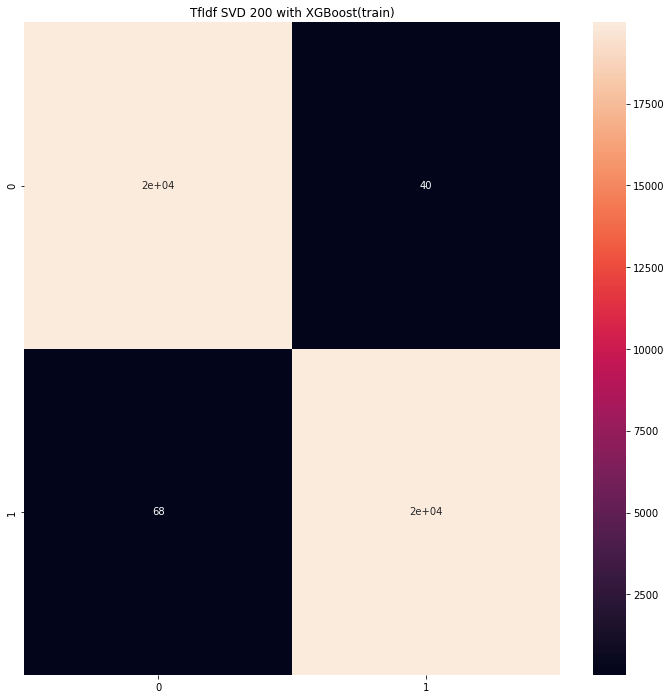

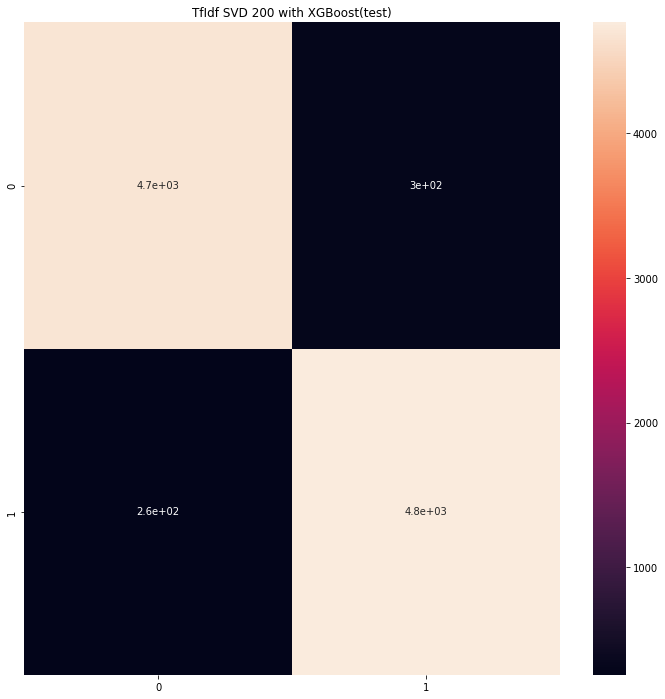

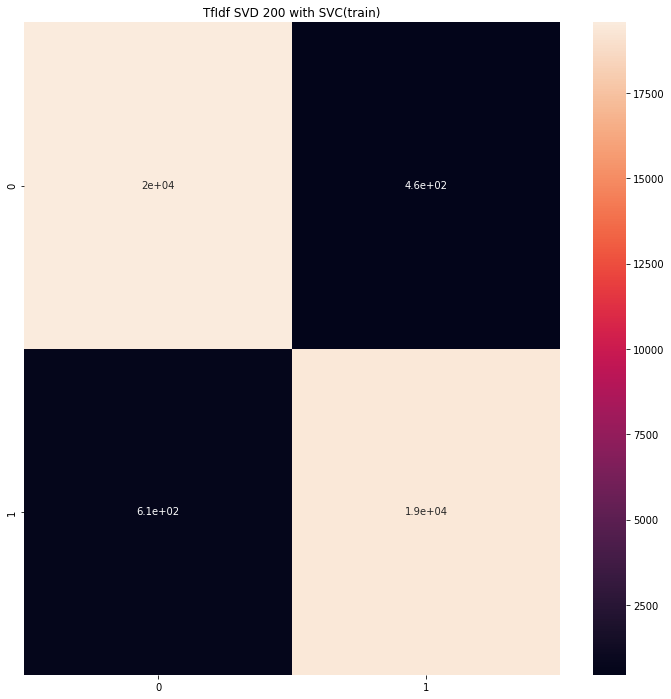

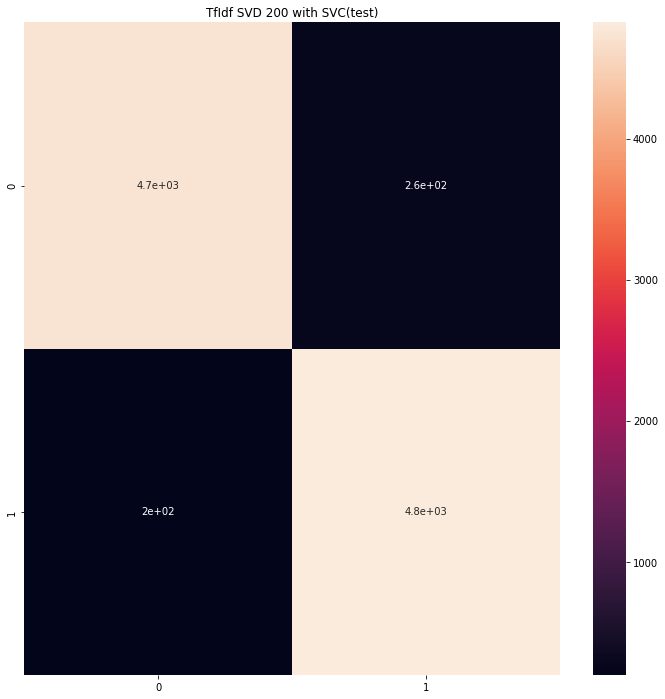

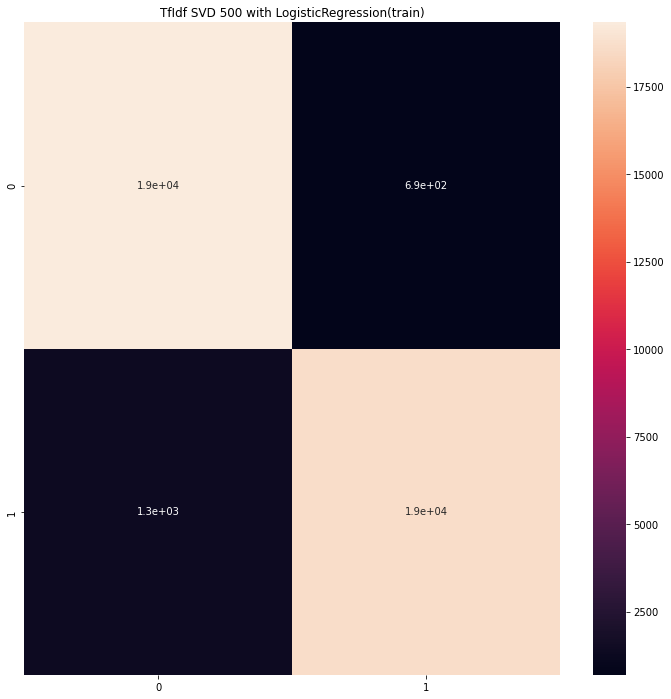

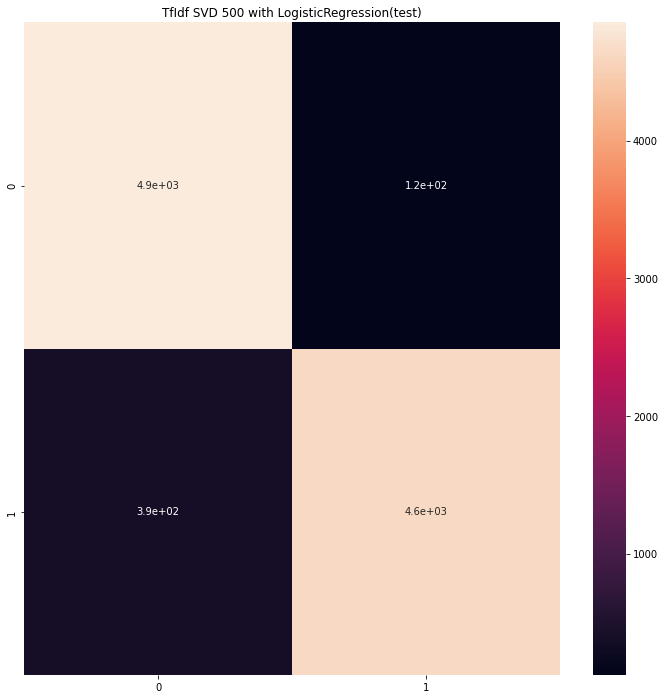

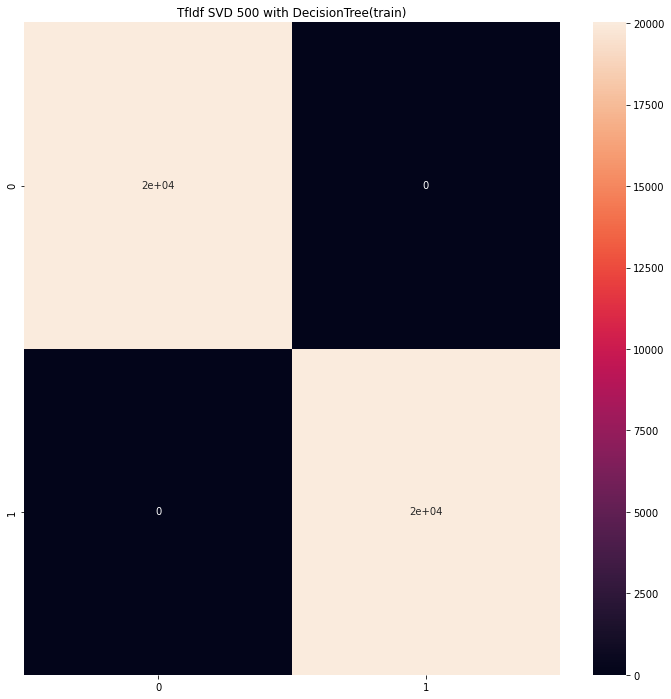

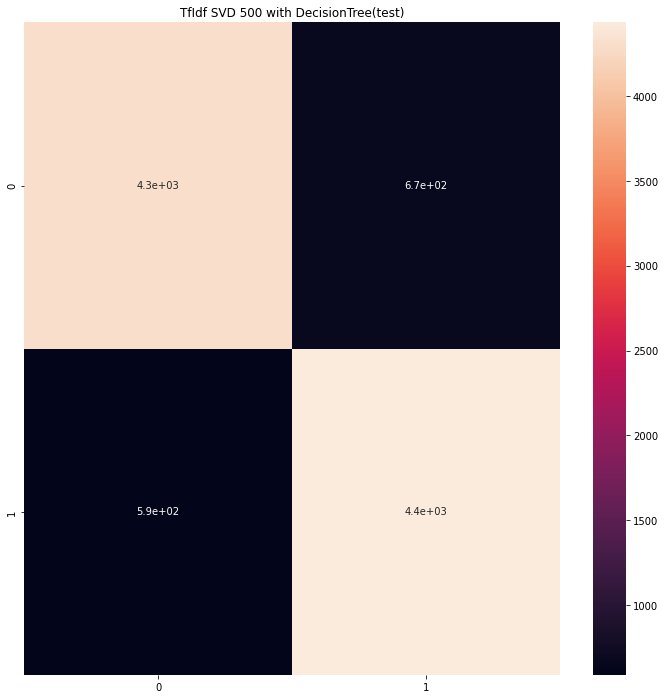

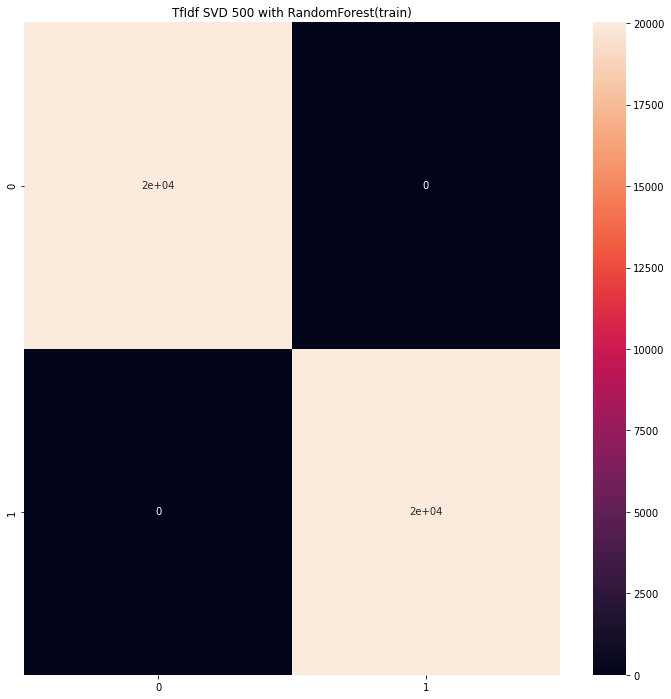

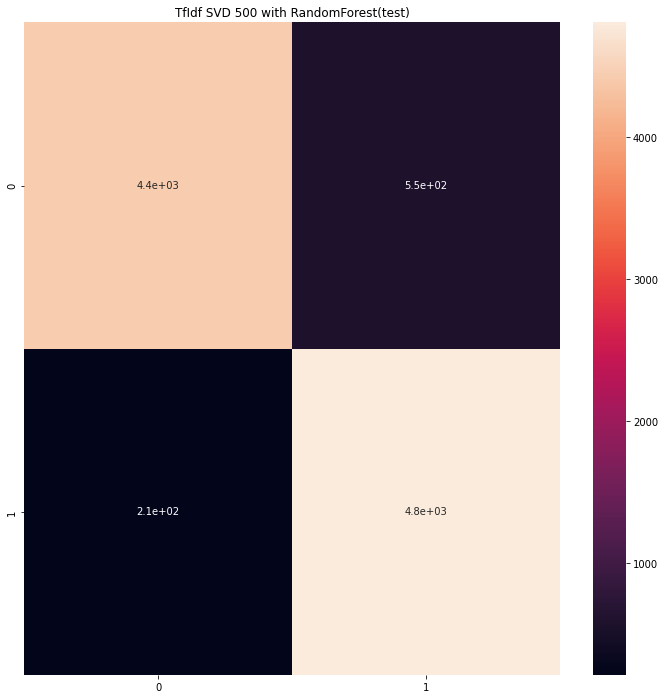

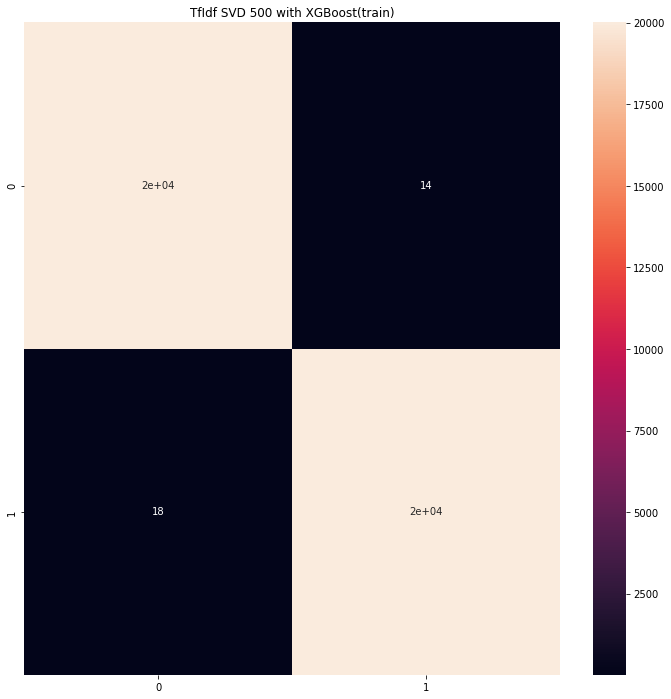

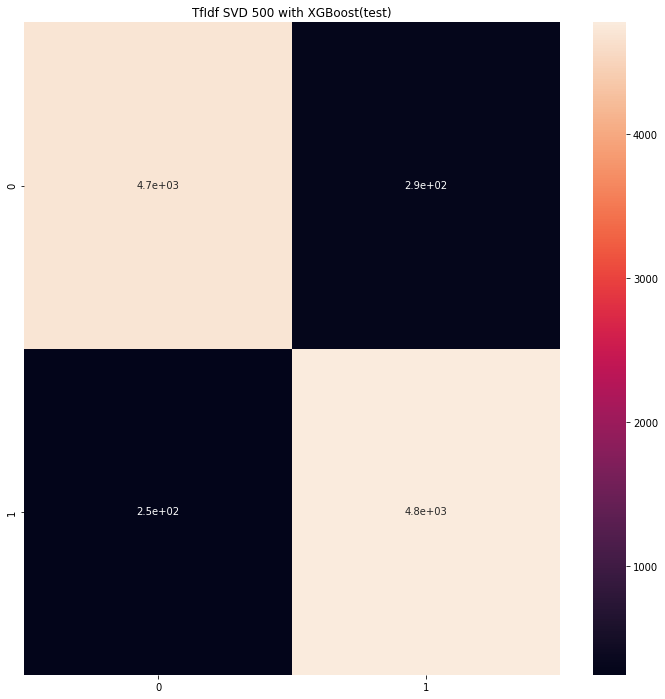

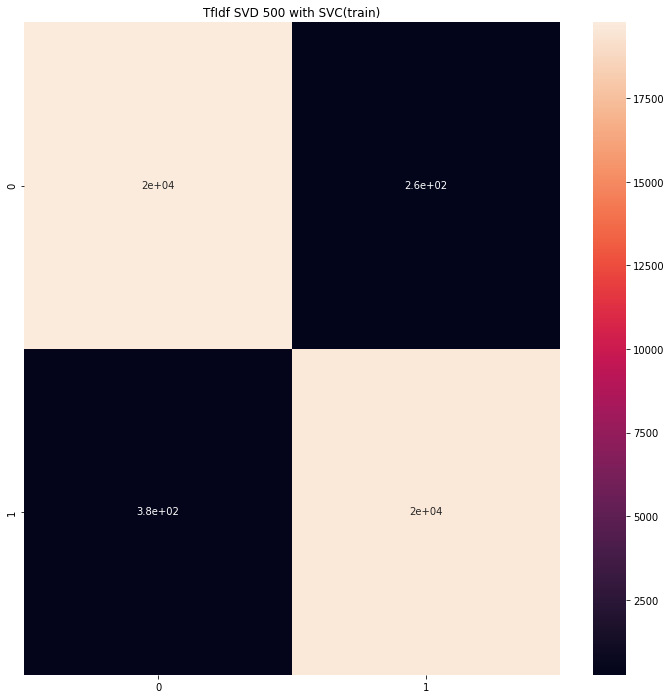

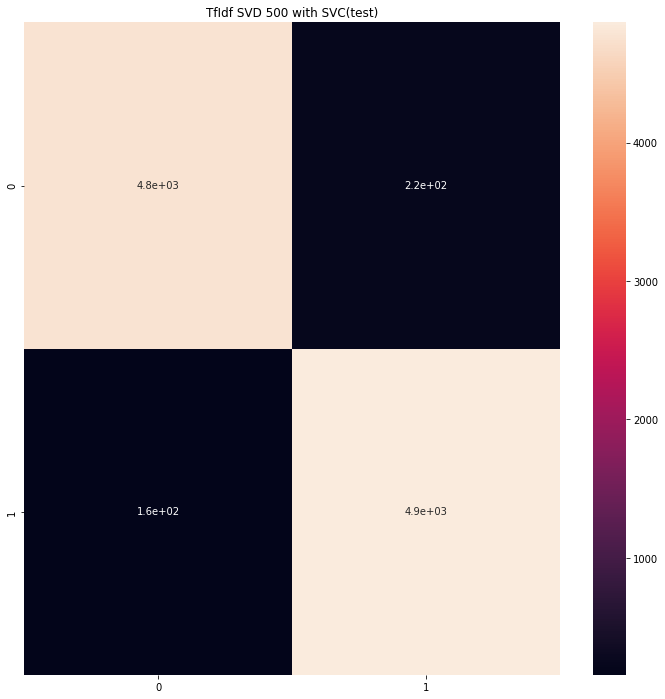

In [ ]:
for consfusion_data in confusions:
    plt.figure(figsize=(12,12))
    plt.title(consfusion_data['Preprocessing'] + ' with ' + consfusion_data['Model'] + '(train)')
    sns.heatmap(consfusion_data['train'], annot=True)
    plt.savefig( 'images/' + consfusion_data['Preprocessing'] + ' with ' + consfusion_data['Model'] + '(train)' + '.jpeg')
    plt.figure(figsize=(12,12))
    plt.title(consfusion_data['Preprocessing'] + ' with ' + consfusion_data['Model'] + '(test)')
    sns.heatmap(consfusion_data['test'], annot=True)
    plt.savefig( 'images/' + consfusion_data['Preprocessing'] + ' with ' + consfusion_data['Model'] + '(test)' + '.jpeg')